In [1]:
import os
import pandas as pd
import numpy as np
import sys
import csv
from time import strptime
import json
from datetime import datetime as dt
from statistics import mean
import math

In [649]:
csv.field_size_limit(sys.maxsize)
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_columns = None
pd.options.display.max_rows = 10000
pd.set_option('display.max_colwidth', -1)

In [3]:
filelist = os.listdir('data/tmdb/raw')
flist = [f for f in filelist if f != 'tmdbdata0_10000.csv']

In [ ]:
# source_dir = 'data/tmdb/raw'
# full_data = pd.read_csv(f'{source_dir}/tmdbdata0_10000.csv')
# for filename in flist:
#     print(filename)
#     data = pd.read_csv(f'{source_dir}/{filename}', engine='python')
#     full_data = full_data.append(data)
# full_data.to_csv('fulltmdb.csv', mode='w+')

In [4]:
full_data = pd.read_csv('data/tmdb/fulltmdb.csv')

In [5]:
full_data.shape

(490257, 30)

In [6]:
full_data.columns

Index(['Unnamed: 0', 'adult', 'backdrop_path', 'belongs_to_collection',
       'budget', 'cast', 'crew', 'genres', 'homepage', 'id', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'status_code', 'status_message', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [7]:
full_data = full_data[full_data['status_message'] != 'The resource you requested could not be found.']

In [8]:
bad_data = full_data[~full_data['adult'].isin(['True', 'False'])]

In [9]:
bad_data.shape

(4919, 30)

In [10]:
full_data_adult_true_false = full_data[full_data['adult'].isin(['True', 'False'])]

In [11]:
full_data_adult_true_false.columns

Index(['Unnamed: 0', 'adult', 'backdrop_path', 'belongs_to_collection',
       'budget', 'cast', 'crew', 'genres', 'homepage', 'id', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'status_code', 'status_message', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [12]:
released = full_data_adult_true_false[full_data_adult_true_false.status == 'Released']

In [13]:
released = released.drop(['Unnamed: 0', 'status', 'status_message', 'status_code', 'backdrop_path', 'homepage', 'poster_path', 'video'], axis=1)

In [14]:
released.columns

Index(['adult', 'belongs_to_collection', 'budget', 'cast', 'crew', 'genres',
       'id', 'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'tagline',
       'title', 'vote_average', 'vote_count'],
      dtype='object')

In [15]:
released.shape

(479672, 22)

In [16]:
released.release_date

0         1938-11-30
1         1921-01-01
2         1962-06-22
3         2003-02-21
4         2008-12-08
             ...    
490252    1977-01-01
490253    1977-01-01
490254    2017-06-04
490255    1916-07-15
490256    2017-11-24
Name: release_date, Length: 479672, dtype: object

In [32]:
def get_date(date):
    try:
        year, month, day = date.split('-')
        is_weekend = str(dt.strptime(date, '%Y-%m-%d').weekday() > 4)
        return year, month, day, is_weekend
    except:
        return ['False' for i in range(4)]

def get_date_lists(df, col):
    list_year, list_month, list_day, list_if_weekend = [], [], [], []
    for i, row in df.iterrows():
        year, month, day, is_weekend = get_date(row[col])
        list_year.append(year)
        list_month.append(month)
        list_day.append(day)
        list_if_weekend.append(is_weekend)
    return list_year, list_month, list_day, list_if_weekend

In [33]:
list_year, list_month, list_day, list_if_weekend = get_date_lists(released, 'release_date')

In [43]:
with_dates = released.copy()
with_dates['year'] = list_year
with_dates['month'] = list_month
with_dates['day'] = list_day
with_dates['weekend'] = list_if_weekend
with_dates = with_dates.drop('release_date', axis=1)

In [45]:
with_dates.shape

(479672, 25)

In [231]:
with_dates_all = with_dates[with_dates.year != 'False']

In [232]:
with_dates_all.shape

(443056, 25)

In [228]:
data_numbers = pd.read_csv('data/cleaned_the_numbers.csv')

In [229]:
data_numbers.shape

(5480, 8)

In [103]:
missing_revenue_budget = with_dates_all[(with_dates_all['revenue'].astype(float) == 0) | (with_dates_all['budget'].astype(float) == 0)]

In [224]:
missing_revenue_budget.shape

(435425, 25)

In [225]:
missing_revenue_budget[missing_revenue_budget.original_title.isin(data_numbers.Movie) | (missing_revenue_budget.title.isin(data_numbers.Movie))].shape

(6718, 25)

In [226]:
numbers_data_to_append = data_numbers[(data_numbers.Movie.isin(missing_revenue_budget.title)) | (data_numbers.Movie.isin(missing_revenue_budget.original_title))]

In [227]:
numbers_data_to_append.shape

(2486, 8)

In [276]:
# add revenue and budget from the numbers if such exists
def get_budget_and_revenue(row, count={'count': 0}):
    count['count'] = count['count'] + 1
    if (row.revenue == '0' or row.budget == '0'):
        item = data_numbers.loc[((data_numbers.Movie == row.title) | (data_numbers.Movie == row.original_title)) & (data_numbers.year == int(row.year))]
        if item.shape[0]:
            print(f'added {count["count"]}')
            row.budget = item.iloc[0].ProductionBudget
            row.revenue = item.iloc[0].WorldwideGross
    return row         

In [277]:
added_revenue_budget = with_dates_all.apply(get_budget_and_revenue, axis=1)

added 23
added 46
added 267
added 286
added 354
added 678
added 692
added 700
added 733
added 794
added 814
added 823
added 842
added 844
added 856
added 879
added 927
added 944
added 960
added 971
added 976
added 998
added 1010
added 1012
added 1014
added 1018
added 1099
added 1101
added 1140
added 1146
added 1167
added 1199
added 1200
added 1255
added 1280
added 1325
added 1331
added 1364
added 1376
added 1407
added 1606
added 1612
added 1652
added 1718
added 1776
added 1832
added 1848
added 1856
added 1858
added 1882
added 1883
added 1886
added 1912
added 2116
added 2271
added 2289
added 2424
added 2592
added 2695
added 2859
added 2955
added 3030
added 3081
added 3093
added 3183
added 3190
added 3224
added 3360
added 3366
added 3386
added 3390
added 3392
added 3410
added 3425
added 3489
added 3559
added 3581
added 3603
added 3647
added 3744
added 3768
added 3880
added 3888
added 3912
added 3921
added 3926
added 3934
added 4029
added 4055
added 4067
added 4082
added 4099
added 4112
a

added 197231
added 198081
added 198222
added 198807
added 198957
added 199240
added 199780
added 200170
added 200530
added 203489
added 205937
added 212401
added 213772
added 216711
added 216928
added 217334
added 217398
added 224128
added 224773
added 225627
added 225980
added 227885
added 233500
added 234710
added 234937
added 235489
added 236810
added 236973
added 237197
added 238224
added 239857
added 240666
added 240686
added 240836
added 241484
added 242396
added 243955
added 244750
added 245604
added 246201
added 246867
added 246922
added 247774
added 248544
added 249029
added 250355
added 250357
added 251597
added 251869
added 251949
added 251965
added 252598
added 253241
added 253269
added 253334
added 253358
added 253534
added 253682
added 254219
added 254236
added 254514
added 255006
added 255102
added 255509
added 256177
added 256475
added 256812
added 257577
added 258259
added 259041
added 260059
added 260068
added 260088
added 260255
added 260363
added 260601
added 260754

In [278]:
added_revenue_budget.to_csv('tmdb_added_rev_budget_from_numbers.csv', mode='w+')

In [ ]:
added_revenue_budget[(added_revenue_budget['revenue'].astype(float) == 0) | (added_revenue_budget['budget'].astype(float) == 0)].shape

In [280]:
added_revenue_budget.shape

(443056, 25)

In [287]:
rev_budget = added_revenue_budget[(added_revenue_budget['revenue'].astype(float) > 0) & (added_revenue_budget['budget'].astype(float) > 0)]

In [300]:
rev_budget.shape

(8696, 24)

In [299]:
rev_budget = rev_budget.drop('adult', axis=1)

In [172]:
import re
def read_as_json(string):
#   get rid of not ascii characters
    s = string.encode("ascii", errors="ignore").decode()
#   replace tabs, new lines, trailing commas, and None, lowercase
    s = s.replace('\t','').replace('\n','').replace(',}','}').replace(',]',']').replace('None', '""').lower()
#   replace all the string wrapped in '' which don't contain "'," or "':" or "'}" (basically end of string in json)
    s = re.sub(r'\'((?:(?!\',|\':|\'\})[a-z0-9 ,_\/\.\:\(\)\&-\[\]\!\?])*)\'', r'"\1"', s)
#   wrap digits into "" as well
    s = re.sub(r' (\d+)(, |\})', r' "\1"\2', s)
    return json.loads(s)

In [10]:
def parse_field_from_str_json(df, col_name, field, convert_to_int, default_nan):
    def convert(val):
        return int(val) if convert_to_int else val
    return [default_nan if pd.isna(c) else convert(read_as_json(c)[field]) for c in df[col_name]]

In [677]:
def remove_collection_ending(string):
    return string.replace(' collection','') if string else string

list_collection_ids = parse_field_from_str_json(rev_budget, 'belongs_to_collection', 'id', True, np.nan)
list_collection_names = parse_field_from_str_json(rev_budget, 'belongs_to_collection', 'name', False, "")
list_collection_names = [remove_collection_ending(name) for name in list_collection_names]

In [674]:
'the chronicles of riddick collection'.replace(' collection','')

'the chronicles of riddick'

In [682]:
added_collections = rev_budget.copy()
added_collections['collection_id'] = list_collection_ids
added_collections['collection_name'] = list_collection_names
added_collections = added_collections.drop('belongs_to_collection', axis=1)

In [684]:
added_collections.columns

Index(['budget', 'cast', 'crew', 'genres', 'id', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'title', 'vote_average', 'vote_count',
       'year', 'month', 'day', 'weekend', 'collection_id', 'collection_name'],
      dtype='object')

In [689]:
np.sort(np.array(added_collections.runtime))

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,
         2.,   2.,   2.,   2.,   2.,   2.,   2.,   3.,   3.,   3.,   3.,
         3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
         3.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   5.,   5.,   5.,
         5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   6.,
         6.,   6.,   6.,   6.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,
         7.,   7.,   7.,   7.,   7.,   7.,   7.,   8.,   8.,   8.,   8.,
         8.,   8.,   9.,   9.,   9.,   9.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.,  10.,  10.,  11.,  11.,  11.,  11.,
        11.,  11.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,  13.,
        13.,  13.,  13.,  13.,  13.,  13.,  13.,  13.,  13.,  13.,  13.,
        14.,  14.,  14.,  14.,  14.,  14.,  15.,  15.,  15.,  15.,  15.,
        15.,  15.,  15.,  15.,  15.,  15.,  16.,  1

In [22]:
added_collections.to_csv('02 tmdb_proceed_collections.csv', mode='w+', index=False)

In [23]:
added_collections = pd.read_csv('02 tmdb_proceed_collections.csv')

In [25]:
len([a for a in added_collections.imdb_id if pd.isna(a)])

314

In [26]:
imdb_basics = pd.read_csv('data/raw/title.basics.tsv', sep='\t')

In [27]:
imdb_basics.columns

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')

In [28]:
imdb_matched = imdb_basics[imdb_basics.tconst.isin(added_collections.imdb_id)]

In [29]:
imdb_matched.shape

(8382, 9)

In [30]:
def isinimdb(row):
    return pd.isna(row.imdb_id)
not_in_imdb = added_collections[added_collections.apply(isinimdb, axis=1)]

In [31]:
def try_get_runtime(item, row, count):
    try:
        print(item.iloc[0].runtimeMinutes)
        runtime = float(item.iloc[0].runtimeMinutes)
        print(runtime)
        if runtime:
            count['count_added'] = count['count_added'] + 1
            print(f'added {count}')
            row.runtime = runtime
            return row
    except ValueError:
        return row

def add_imdb_id_to_missing(row, count={'count': 0, 'count_added':0}):
    count['count'] = count['count'] + 1
    print(count['count'])
    if pd.isna(row.runtime) or row.runtime < 20:
        print('runtime isna')
        if not pd.isna(row.imdb_id):
            print('imdb id exists')
            imdb_item = imdb_basics[imdb_basics.tconst == row.imdb_id]
            print('item searched')
            if imdb_item.shape[0]:
                print('name item exists')
                return try_get_runtime(imdb_item, row, count)
        print('item search title')
        imdb_item = imdb_basics.loc[(imdb_basics.originalTitle == row.original_title) | (imdb_basics.primaryTitle == row.title)]
        print('title item found')
        if imdb_item.shape[0]:
            print('item exists')
            return try_get_runtime(imdb_item, row, count)
    return row

In [32]:
not_in_imdb[(not_in_imdb.original_title.isin(imdb_basics.originalTitle)) | (not_in_imdb.title.isin(imdb_basics.primaryTitle))].shape

(127, 25)

In [33]:
with_added_imdb_runtime = added_collections.apply(add_imdb_id_to_missing, axis=1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230


title item found
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
runtime isna
imdb id exists
item searched
name item exists
6
6.0
added {'count': 3616, 'count_added': 6}
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
runtime isna
item search title
title item found
item exists
133
133.0
added {'count': 3627, 'count_added': 7}
3628
3629
3630
3631
3632
runtime isna
imdb id exists
item searched
name item exists
106
106.0
added {'count': 3632, 'count_added': 8}
3633
3634
runtime isna
imdb id exists
item searched
name item exists


title item found
4038
runtime isna
item search title
title item found
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224


item searched
name item exists
19
19.0
added {'count': 5254, 'count_added': 62}
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
runtime isna
item search title
title item found
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
runtime isna
imdb id exists
item searched
name item exists
86
86.0
added {'count': 5287, 'count_added': 63}
5288
5289
5290
5291
5292
5293
5294
5295
runtime isna
imdb id exists
item searched
name item exists
75
75.0
added {'count': 5295, 'count_added': 64}
5296
5297
5298
5299
5300
5301
runtime isna
imdb id exists
item searched
name item exists
119
119.0
added {'count': 5301, 'count_added': 65}
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
runtime isna
imdb id exists
item searched
name item exists
\N
5335
runtime isna
imdb id exists
item searched
name item exists
93
93.0
added {'coun

item searched
name item exists
99
99.0
added {'count': 5851, 'count_added': 96}
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
runtime isna
item search title
title item found
item exists
20
20.0
added {'count': 5880, 'count_added': 97}
5881
runtime isna
imdb id exists
item searched
name item exists
90
90.0
added {'count': 5881, 'count_added': 98}
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
runtime isna
item search title
title item found
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
runti

item searched
name item exists
115
115.0
added {'count': 7311, 'count_added': 115}
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
runtime isna
imdb id exists
item searched
name item exists
87
87.0
added {'count': 7321, 'count_added': 116}
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349
7350
7351
7352
7353
7354
7355
7356
7357
7358
7359
7360
7361
7362
7363
7364
7365
7366
7367
7368
7369
7370
7371
7372
7373
7374
7375
7376
7377
7378
7379
7380
7381
7382
7383
7384
runtime isna
item search title
title item found
7385
7386
7387
7388
7389
7390
7391
7392
7393
7394
7395
7396
7397
7398
7399
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434
runtime isna
imdb id exists
item searched
name item exists
\N
7435
7436
7437
7438
7439
7440
7441
7442
7443
7444
7445
7446
7447
7448
7449
7450
745

title item found
7952
7953
7954
7955
7956
7957
7958
7959
7960
7961
7962
7963
7964
7965
7966
7967
7968
7969
7970
7971
7972
7973
7974
7975
7976
7977
7978
7979
7980
7981
7982
7983
7984
7985
runtime isna
imdb id exists
item searched
name item exists
95
95.0
added {'count': 7985, 'count_added': 150}
7986
7987
runtime isna
imdb id exists
item searched
name item exists
103
103.0
added {'count': 7987, 'count_added': 151}
7988
7989
7990
7991
7992
7993
7994
7995
7996
7997
7998
7999
8000
8001
8002
8003
8004
8005
8006
8007
8008
8009
8010
8011
8012
8013
8014
8015
8016
8017
8018
8019
8020
runtime isna
item search title
title item found
8021
8022
8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034
8035
8036
8037
runtime isna
item search title
title item found
item exists
14
14.0
added {'count': 8037, 'count_added': 152}
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
runtime isna
imdb id exists
item searched
name item exists
100
10

In [36]:
with_added_imdb_runtime.shape

(8696, 25)

In [42]:
np.sort(np.array(with_added_imdb_runtime.runtime.unique()))

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  30.,  31.,  32.,  34.,  35.,
        37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  48.,
        49.,  50.,  51.,  52.,  53.,  54.,  55.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
        72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       116., 117., 118., 119., 120., 121., 122., 123., 124., 125., 126.,
       127., 128., 129., 130., 131., 132., 133., 134., 135., 136., 137.,
       138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148.,
       149., 150., 151., 152., 153., 154., 155., 15

In [68]:
len([a for a in with_added_imdb_runtime.runtime if pd.isna(a)])

62

In [77]:
def fine_runtime(row):
    runtime = row.runtime
    if pd.isna(runtime) or runtime < 15 or runtime > 400:
        row.runtime = False
    return row

with_filter_applied = with_added_imdb_runtime.apply(fine_runtime, axis=1)
cleaned_runtime_df = with_filter_applied[with_filter_applied.runtime != False]

In [86]:
cleaned_runtime_df.shape

(8516, 25)

In [84]:
cleaned_runtime_df.weekend = cleaned_runtime_df.weekend.astype(int)

/home/stas/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [141]:
cleaned_runtime_df[cleaned_runtime_df.spoken_languages == '[]'].shape

(217, 25)

In [111]:
cleaned_runtime_df.shape

(8516, 25)

In [142]:
cleaned_arrays = cleaned_runtime_df[(cleaned_runtime_df.cast != '[]') & (cleaned_runtime_df.crew != '[]') & (cleaned_runtime_df.production_countries != '[]') & (cleaned_runtime_df.production_companies != '[]') & (cleaned_runtime_df.genres != '[]') & (cleaned_runtime_df.spoken_languages != '[]')]

In [144]:
cleaned_arrays.shape

(7672, 25)

In [145]:
cleaned_arrays.head(5)

,budget,cast,crew,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,year,month,day,weekend,collection_id,collection_name
0,4000000,"[{'cast_id': 42, 'character': 'Ted the Bellhop...","[{'credit_id': '52fe420dc3a36847f800012d', 'de...","[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5.0,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,11.799,"[{'id': 14, 'logo_path': '/m6AHu84oZQxvq7n1rsv...","[{'iso_3166_1': 'US', 'name': 'United States o...",4257354,98,"[{'iso_639_1': 'en', 'name': 'English'}]",Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.0,1421.0,1995,12,9,1,NaN,NaN
1,21000000,"[{'cast_id': 7, 'character': 'Frank Wyatt', 'c...","[{'credit_id': '52fe420dc3a36847f800023d', 'de...","[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",6.0,tt0107286,en,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",9.240,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",12136938,110,"[{'iso_639_1': 'en', 'name': 'English'}]",Don't move. Don't whisper. Don't even breathe.,Judgment Night,6.6,132.0,1993,10,15,0,NaN,NaN
2,11000000,"[{'cast_id': 3, 'character': 'Luke Skywalker',...","[{'credit_id': '52fe420dc3a36847f8000437', 'de...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",11.0,tt0076759,en,Star Wars,Princess Leia is captured and held hostage by ...,42.717,"[{'id': 1, 'logo_path': '/o86DbpburjxrqAzEDhXZ...","[{'iso_3166_1': 'US', 'name': 'United States o...",775398007,121,"[{'iso_639_1': 'en', 'name': 'English'}]","A long time ago in a galaxy far, far away...",Star Wars,8.2,12818.0,1977,5,25,0,10.0,star wars
3,94000000,"[{'cast_id': 8, 'character': 'Marlin (voice)',...","[{'credit_id': '52fe420ec3a36847f80006b1', 'de...","[{'id': 16, 'name': 'Animation'}, {'id': 10751...",12.0,tt0266543,en,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",24.702,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...","[{'iso_3166_1': 'US', 'name': 'United States o...",940335536,100,"[{'iso_639_1': 'en', 'name': 'English'}]",There are 3.7 trillion fish in the ocean. They...,Finding Nemo,7.8,12809.0,2003,5,30,0,137697.0,finding nemo
4,55000000,"[{'cast_id': 7, 'character': 'Forrest Gump', '...","[{'credit_id': '52fe420ec3a36847f800076b', 'de...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",13.0,tt0109830,en,Forrest Gump,A man with a low IQ has accomplished great thi...,29.756,"[{'id': 4, 'logo_path': '/fycMZt242LVjagMByZOL...","[{'iso_3166_1': 'US', 'name': 'United States o...",677387716,142,"[{'iso_639_1': 'en', 'name': 'English'}]",Life is like a box of chocolates...you never k...,Forrest Gump,8.4,16699.0,1994,7,6,0,NaN,NaN


In [148]:
cleaned_arrays.to_csv('03 tmdb_discard_empty_runtime_cast_crew_country_company_genres_languages.csv', mode='w+', index=False)

In [157]:
cleaned_arrays = pd.read_csv('03 tmdb_discard_empty_runtime_cast_crew_country_company_genres_languages.csv')

In [150]:
def grab_field_from_array_of_objects(array, field):
    return [item[field] for item in array]

def sorted_string_from_array(array):
    return ','.join(list(np.sort(np.array(array))))

def parse_field_from_str_json_array(df, col_name, field):
    list_of_items = [read_as_json(c) for c in df[col_name]]
    list_of_fields = [grab_field_from_array_of_objects(item, field) for item in list_of_items]
    return [sorted_string_from_array(item) for item in list_of_fields]

In [198]:
list_of_languages = parse_field_from_str_json_array(cleaned_arrays, 'spoken_languages', 'iso_639_1')
list_of_countries = parse_field_from_str_json_array(cleaned_arrays, 'production_countries', 'iso_3166_1')
list_of_genres = parse_field_from_str_json_array(cleaned_arrays, 'genres', 'name')

In [199]:
parsed_lang_country_genre = cleaned_arrays.copy()
parsed_lang_country_genre['spoken_languages'] = list_of_languages
parsed_lang_country_genre['production_countries'] = list_of_countries
parsed_lang_country_genre['genres'] = list_of_genres

In [226]:
def number_of_unique_if_comma_string(df, field):
    values = []
    for v in df[field]:
        values.extend(v.split(','))
    return len(list(dict.fromkeys(values)))

In [227]:
print(f"spoken languages {number_of_unique_if_comma_string(parsed_lang_country_genre, 'spoken_languages')}")
print(f"production countries {number_of_unique_if_comma_string(parsed_lang_country_genre, 'production_countries')}")
print(f"genres {number_of_unique_if_comma_string(parsed_lang_country_genre, 'genres')}")
print(f"original languages {parsed_lang_country_genre.original_language.unique().shape[0]}")

spoken languages 103
production countries 111
genres 19
original languages 61


In [228]:
parsed_lang_country_genre.to_csv('04 tmdb_parsed_lang_country_genre.csv', mode='w+', index=False)

In [89]:
parsed_lang_country_genre = pd.read_csv('04 tmdb_parsed_lang_country_genre.csv')

In [90]:
parsed_lang_country_genre.head(5)

,budget,cast,crew,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,year,month,day,weekend,collection_id,collection_name
0,4000000,"[{'cast_id': 42, 'character': 'Ted the Bellhop...","[{'credit_id': '52fe420dc3a36847f800012d', 'de...","comedy,crime",5,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,11.799,"[{'id': 14, 'logo_path': '/m6AHu84oZQxvq7n1rsv...",us,4257354,98,en,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.0,1421,1995,12,9,1,NaN,NaN
1,21000000,"[{'cast_id': 7, 'character': 'Frank Wyatt', 'c...","[{'credit_id': '52fe420dc3a36847f800023d', 'de...","action,crime,thriller",6,tt0107286,en,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",9.240,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","jp,us",12136938,110,en,Don't move. Don't whisper. Don't even breathe.,Judgment Night,6.6,132,1993,10,15,0,NaN,NaN
2,11000000,"[{'cast_id': 3, 'character': 'Luke Skywalker',...","[{'credit_id': '52fe420dc3a36847f8000437', 'de...","action,adventure,science fiction",11,tt0076759,en,Star Wars,Princess Leia is captured and held hostage by ...,42.717,"[{'id': 1, 'logo_path': '/o86DbpburjxrqAzEDhXZ...",us,775398007,121,en,"A long time ago in a galaxy far, far away...",Star Wars,8.2,12818,1977,5,25,0,10.0,star wars
3,94000000,"[{'cast_id': 8, 'character': 'Marlin (voice)',...","[{'credit_id': '52fe420ec3a36847f80006b1', 'de...","animation,family",12,tt0266543,en,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",24.702,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...",us,940335536,100,en,There are 3.7 trillion fish in the ocean. They...,Finding Nemo,7.8,12809,2003,5,30,0,137697.0,finding nemo
4,55000000,"[{'cast_id': 7, 'character': 'Forrest Gump', '...","[{'credit_id': '52fe420ec3a36847f800076b', 'de...","comedy,drama,romance",13,tt0109830,en,Forrest Gump,A man with a low IQ has accomplished great thi...,29.756,"[{'id': 4, 'logo_path': '/fycMZt242LVjagMByZOL...",us,677387716,142,en,Life is like a box of chocolates...you never k...,Forrest Gump,8.4,16699,1994,7,6,0,NaN,NaN


In [72]:
def read_as_json2(string):
#   get rid of not ascii characters
    s = string.encode("ascii", errors="ignore").decode()
#   just to get rid of those character which are malformed in many cases
    s = re.sub(r'(character.*?)(credit_id)', r'\2', s)
#   replace tabs, new lines, trailing commas, and None, lowercase
    s = s.replace('\t','').replace('\\t', '').replace('\r', '').replace('\n','').replace(',}','}').replace(',]',']').replace('None,', '\'\',').replace(':\'', ': \'').lower()
    allowed_symbols = '[a-z0-9 ,_\`\/\.@\+\:\(\)\&\[\]\!\?\#\$-]'
#   to deal with enclosed double quotes
    t = f'(?:(?!\',|\':|, \'|: \'|\'\}}){allowed_symbols})*'
    s = re.sub(fr'\'({t})"({t})"({t})\'', r'"\1\2\3"', s).replace("\'", "'")
#   replace all the string wrapped in '' which don't contain "'," or "':" or "'}" (basically end of string in json)
    s = re.sub(fr'( |\{{)\'({t})\'(,|:|\}})', r'\1"\2"\3', s)
    try:
        return json.loads(s)
    except:
        print('\n\n\n\n\n\n\n')
        print(s)

In [58]:
def grab_fields_from_array_of_objects(array, fields):
    new_array = []
    for item in array:
        new_item = {}
        for field in fields:
            new_item[field] = item.get(field, '')
        new_array.append(new_item)
    return new_array

def parse_fields_from_str_json_array(df, col_name, fields):
    list_of_items = [read_as_json2(c) for c in df[col_name]]
    return [grab_fields_from_array_of_objects(item, fields) for item in list_of_items]

In [93]:
cast_attrs = ['id', 'gender', 'name', 'order']
cast = parse_fields_from_str_json_array(parsed_lang_country_genre, 'cast', cast_attrs)

In [94]:
parsed_cast = parsed_lang_country_genre.copy()
parsed_cast.cast = cast

In [95]:
parsed_cast.columns

Index(['budget', 'cast', 'crew', 'genres', 'id', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'title', 'vote_average', 'vote_count',
       'year', 'month', 'day', 'weekend', 'collection_id', 'collection_name'],
      dtype='object')

In [96]:
trimmed_budget_revenue = parsed_cast[(parsed_cast.budget >= 1000) | (parsed_cast.revenue >= 1000)]

In [97]:
trimmed_budget_revenue.shape

(7580, 25)

In [98]:
np.sort(np.array([len(cast) for cast in parsed_cast.cast]))

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   5,   5,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   

In [99]:
len([cast for cast in trimmed_budget_revenue.cast if len(cast) < 10])

894

In [100]:
def leave_only_10_main_actors(row):
    cast = row.cast
    row.cast = cast[:min(len(cast), 10)]
    return row

In [101]:
reduced_cast = trimmed_budget_revenue.apply(leave_only_10_main_actors, axis=1)

In [124]:
def move_from_list_of_objects_into_columns(df, field, number_items, new_fields):
    result = {}
    for i in range(1, number_items+1):
        for subfield in new_fields:
            field_name = f'{field}_{str(i)}_{subfield}'
            result[field_name] = []
    
    for row in df.iterrows():
        cast = row[1].cast
        for i in5bb range(number_items):
            person = next((p for p in cast if p['order'] == i), {'id':0, 'gender':0, 'name':'', 'order': i})
            order = str(person['order']+1)
            for subfield in [key for key in person.keys() if key != 'order']:
                result[f'{field}_{order}_{subfield}'].append(person[subfield])
    return result

In [125]:
cast_columns = move_from_list_of_objects_into_columns(reduced_cast, 'cast', 10, ['id', 'name', 'gender'])

In [126]:
added_cast_columns = reduced_cast.copy()
for column in list(cast_columns.keys()):
    added_cast_columns[column] = cast_columns[column]

In [129]:
added_cast_columns.to_csv('05 added_cast_columns.csv', mode='w+', index=False)

In [223]:
added_cast_columns = pd.read_csv('05 added_cast_columns.csv')

In [224]:
crew_attrs = ['department', 'gender', 'id', 'job', 'name']
crew = parse_fields_from_str_json_array(added_cast_columns, 'crew', crew_attrs)

In [225]:
parsed_crew = added_cast_columns.copy()
parsed_crew.crew = crew

In [226]:
for row in parsed_crew.iterrows():
    crew = row[1].crew
    for person in crew:
        if not person['department'] or not person['job'] or person['department'] == 'lightig':
            crew.remove(person)

In [227]:
for row in parsed_crew.iterrows():
    crew = row[1].crew
    for person in reversed(crew):
        if (person['job'] == 'other' 
                or person['job'] == 'stung double'
                or ('assistant' in person['job'] and person['department'] != 'directing')
                or 'trainee' in person['job'] 
                or 'intern' in person['job']
                or 'thanks' in person['job']):
            crew.remove(person)
            continue
        if person['department'] in ['visual effects', 'visual ffects', 'visual effets', 'visua effects']: 
            person['department'] = 'visualeffects'
        if person['department'] == 'costume & make-up': 
            person['department'] = 'costume'
        if person['department'] == 'sound' and job == 'dialogue editor': 
            person['department'] = 'editing'
        if person['department'] == 'crew':
            if person['job'] == 'sound recordist': 
                person['department'] = 'sound'
            if person['job'] == 'unit production manager': 
                person['department'] = 'production'
            if (person['job'] == 'art direction'
                    or person['job'] == 'property master'
                    or person['job'] == 'supervising art director'):
                person['department'] = 'art'
            if person['job'] == 'stunt double': 
                person['department'] = 'actors'
            if person['job'] == 'digital effects producer': 
                person['department'] = 'visualeffects'
        if person['job'] in ['costume design']:
            person['job'] = 'costume designer'
        person['job'] = re.sub(r'( |/|-)', '_', person['job'].replace(' / ', '/'))
        person['job'] = re.sub(r'_\(.*\)', '', person['job'])

In [228]:
unique_jobs = list(set([person["job"] for crew in parsed_crew.crew for person in crew]))

In [229]:
len(unique_jobs)

722

In [230]:
unique_jobs

['additional_editor',
 'projection',
 'editorial_staff',
 'cast_driver',
 'second_unit_director',
 'armory_coordinator',
 'series_writer',
 'legal_services',
 'standby_art_director',
 'special_effects',
 '3d_supervisor',
 'novel',
 'unit_publicist',
 'costume_illustrator',
 'pyrotechnic_supervisor',
 'digital_color_timer',
 'russian_arm_operator',
 'scenario_writer',
 '3d_artist',
 'additional_writing',
 'pyrotechnician',
 'extras_casting_coordinator',
 'paint_coordinator',
 'dailies_manager',
 'weapons_wrangler',
 'senior_visual_effects_supervisor',
 'visual_effects_producer',
 'epk_camera_operator',
 'boom_operator',
 'story_consultant',
 'painter',
 'additional_editing',
 'video_assist_operator',
 'hairdresser',
 'wardrobe_coordinator',
 'best_boy_grip',
 'sound',
 'music_director',
 'wardrobe_specialized_technician',
 'keyboard_programmer',
 'music_editor',
 'lead_animator',
 'prosthetics',
 'modelling_supervisor',
 'location_casting',
 'security_coordinator',
 'supervising_film_ed

In [231]:
departments_list = list(set([person["department"] for crew in parsed_crew.crew for person in crew]))

In [232]:
departments_list

['lighting',
 'sound',
 'directing',
 'production',
 'editing',
 'costume',
 'crew',
 'writing',
 'art',
 'visualeffects',
 'actors',
 'camera']

In [233]:
dict_jobs = {}
for department in departments_list:
    dict_jobs[department] = []
for row in parsed_crew.iterrows():
    crew = row[1].crew
    for person in crew:
        if person['job'] not in dict_jobs[person['department']]:
            dict_jobs[person['department']].append(person['job'])

In [234]:
for key in dict_jobs.keys():
    dict_jobs[key] = list(np.sort(np.array(dict_jobs[key])))

In [235]:
dict_jobs

{'lighting': ['additional_gaffer',
  'additional_lighting_technician',
  'best_boy_electric',
  'best_boy_electrician',
  'best_boy_eletric',
  'best_boy_lighting_technician',
  'bet_boy_electric',
  'chief_lighting_technician',
  'directing_lighting_artist',
  'electrician',
  'gaffer',
  'genetator_operator',
  'key_rigging_grip',
  'lighting_artist',
  'lighting_coordinator',
  'lighting_design',
  'lighting_director',
  'lighting_manager',
  'lighting_programmer',
  'lighting_supervisor',
  'lighting_technician',
  'master_lighting_artist',
  'rigging_gaffer',
  'rigging_grip',
  'rigging_supervisor',
  'standby_rigger',
  'underwater_gaffer'],
 'sound': ['additional_music_supervisor',
  'additional_production_sound_mixer',
  'additional_sound_re_recording_mixer',
  'additional_sound_re_recordist',
  'additional_soundtrack',
  'adr_&_dubbing',
  'adr_coordinator',
  'adr_editor',
  'adr_engineer',
  'adr_mixer',
  'adr_recording_engineer',
  'adr_recordist',
  'adr_supervisor',
  '

In [236]:
parsed_crew.shape

(7574, 55)

In [237]:
# maximum number of people in one job
num_of_people = {}
for row in parsed_crew.iterrows():
    crew = row[1].crew
    jobs = {}
    for person in crew:
        if person['job'] not in jobs.keys():
            jobs[person['job']] = 1
        else:
            jobs[person['job']] += 1
    for job, number in jobs.items():
        if job not in num_of_people.keys():
            num_of_people[job] = number
        else:
            num_of_people[job] = max(number, num_of_people[job])

In [238]:
sorted_num_of_people = {k: v for k, v in sorted(num_of_people.items(), key=lambda item: item[1])}

In [239]:
sorted_num_of_people

{'camera_supervisor': 1,
 'story_supervisor': 1,
 'general_manager': 1,
 '24_frame_playback': 1,
 'wardrobe_designer': 1,
 'post_production_consulting': 1,
 '3d_coordinator': 1,
 'vehicles_coordinator': 1,
 'visual_effects_camera': 1,
 'pyrotechnic_supervisor': 1,
 'color_grading': 1,
 'digital_supervisor': 1,
 'set_decorating_coordinator': 1,
 'creative_director': 1,
 'production_driver': 1,
 'digital_color_timer': 1,
 'logistics_coordinator': 1,
 'set_dressing_supervisor': 1,
 'senior_visual_effects_supervisor': 1,
 'security_coordinator': 1,
 'decorator': 1,
 'shop_electric': 1,
 'key_construction_grip': 1,
 'additional_colorist': 1,
 'wig_designer': 1,
 'unit_medic': 1,
 'steadycam': 1,
 'visual_effects_design_consultant': 1,
 'prosthetics_sculptor': 1,
 'weapons_master': 1,
 '3d_director': 1,
 'creative_producer': 1,
 'camera_truck': 1,
 'short_story': 1,
 'underwater_director_of_photography': 1,
 'extras_dresser': 1,
 'truck_supervisor': 1,
 'special_guest_director': 1,
 'graphic

In [240]:
# find average number of people with each proffession per movie
movies_proffessions = []
for row in parsed_crew.iterrows():
    crew = row[1].crew
    jobs = {k: 0 for k in unique_jobs}
    for person in crew:
        jobs[person['job']] += 1
    movies_proffessions.append(jobs)

In [241]:
average_per_job = {job: math.ceil(mean([movie[job] for movie in movies_proffessions])) for job in unique_jobs}

In [242]:
{k: v for k, v in sorted(average_per_job.items(), key=lambda item: item[1])}

{'additional_editor': 1,
 'projection': 1,
 'editorial_staff': 1,
 'cast_driver': 1,
 'second_unit_director': 1,
 'armory_coordinator': 1,
 'series_writer': 1,
 'legal_services': 1,
 'standby_art_director': 1,
 'special_effects': 1,
 '3d_supervisor': 1,
 'novel': 1,
 'unit_publicist': 1,
 'costume_illustrator': 1,
 'pyrotechnic_supervisor': 1,
 'digital_color_timer': 1,
 'russian_arm_operator': 1,
 'scenario_writer': 1,
 '3d_artist': 1,
 'additional_writing': 1,
 'pyrotechnician': 1,
 'extras_casting_coordinator': 1,
 'paint_coordinator': 1,
 'dailies_manager': 1,
 'weapons_wrangler': 1,
 'senior_visual_effects_supervisor': 1,
 'visual_effects_producer': 1,
 'epk_camera_operator': 1,
 'boom_operator': 1,
 'story_consultant': 1,
 'painter': 1,
 'additional_editing': 1,
 'video_assist_operator': 1,
 'hairdresser': 1,
 'wardrobe_coordinator': 1,
 'best_boy_grip': 1,
 'sound': 1,
 'music_director': 1,
 'wardrobe_specialized_technician': 1,
 'keyboard_programmer': 1,
 'music_editor': 1,
 'l

In [243]:
len(average_per_job.keys())

722

In [244]:
all_jobs = []
for department, jobs in dict_jobs.items():
    for job in jobs:
        all_jobs.append(job)

In [245]:
len(all_jobs)

723

In [246]:
result = {}
for department, jobs in dict_jobs.items():
    for job in jobs:
        number_times = average_per_job[job]
        column_name = f'crew__{department}__{job}'
        if number_times > 1:
            for i in range(number_times):
                result[f'{column_name}__{i+1}'] = []
        else:
            result[column_name] = []
for row in parsed_crew.iterrows():
    crew = row[1].crew
    for column in result.keys():
        column_list = column.split('__')
        department, job = column_list[1], column_list[2]
        order = 1
        if len(column_list) == 4:
            order = int(column_list[3])
        names = iter([p['name'] for p in crew if p['job'] == job and p['department'] == department])
        if order == 1:
            result[column].append(next(names, ''))
        else:
            for order in range(order):
                _ = next(names, '')
            result[column].append(next(names, ''))

In [247]:
list(result.keys())

['crew__lighting__additional_gaffer',
 'crew__lighting__additional_lighting_technician',
 'crew__lighting__best_boy_electric',
 'crew__lighting__best_boy_electrician',
 'crew__lighting__best_boy_eletric',
 'crew__lighting__best_boy_lighting_technician',
 'crew__lighting__bet_boy_electric',
 'crew__lighting__chief_lighting_technician',
 'crew__lighting__directing_lighting_artist',
 'crew__lighting__electrician',
 'crew__lighting__gaffer',
 'crew__lighting__genetator_operator',
 'crew__lighting__key_rigging_grip',
 'crew__lighting__lighting_artist',
 'crew__lighting__lighting_coordinator',
 'crew__lighting__lighting_design',
 'crew__lighting__lighting_director',
 'crew__lighting__lighting_manager',
 'crew__lighting__lighting_programmer',
 'crew__lighting__lighting_supervisor',
 'crew__lighting__lighting_technician',
 'crew__lighting__master_lighting_artist',
 'crew__lighting__rigging_gaffer',
 'crew__lighting__rigging_grip',
 'crew__lighting__rigging_supervisor',
 'crew__lighting__standb

In [248]:
num_results = {}
for key in list(result.keys()):
    not_null = len([tmp for tmp in result[key] if tmp != ''])
    num_results[key] = not_null
{k: v for k, v in sorted(num_results.items(), key=lambda item: item[1])}

{'crew__lighting__best_boy_eletric': 1,
 'crew__lighting__bet_boy_electric': 1,
 'crew__lighting__directing_lighting_artist': 1,
 'crew__sound__keyboard_programmer': 1,
 'crew__sound__music_co_supervisor': 1,
 'crew__sound__music_sound_design_and_processing': 1,
 'crew__sound__sound_effects_editr': 1,
 'crew__sound__sound_montage_associate': 1,
 'crew__sound__sound_post_production_coordinator': 1,
 'crew__sound__supevising_sound_editor': 1,
 'crew__directing__insert_unit_director': 1,
 'crew__directing__stage_director': 1,
 'crew__production__accounting_supervisor': 1,
 'crew__production__post_production_technical_engineer': 1,
 'crew__production__producton_manager': 1,
 'crew__editing__archival_footage_coordinator': 1,
 'crew__editing__atmos_editor': 1,
 'crew__editing__digital_intermediate_roducer': 1,
 'crew__costume__costume_mistress': 1,
 'crew__costume__costume_supervisr': 1,
 'crew__costume__wardrobe_specialized_technician': 1,
 'crew__crew__acting_double': 1,
 'crew__crew__base

In [252]:
parsed_crew.shape[0]/10

757.4

In [254]:
keys_to_left = [key for key, num in num_results.items() if num > 757]

In [256]:
len(keys_to_left)

63

In [257]:
reduced_result = { key: result[key] for key in keys_to_left}

In [258]:
added_crew_columns = parsed_crew.copy()
for column in list(reduced_result.keys()):
    added_crew_columns[column] = reduced_result[column]

In [262]:
added_crew_columns = added_crew_columns.drop(['cast', 'crew'], axis=1)

In [263]:
list(added_crew_columns.columns)

['budget',
 'genres',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'revenue',
 'runtime',
 'spoken_languages',
 'tagline',
 'title',
 'vote_average',
 'vote_count',
 'year',
 'month',
 'day',
 'weekend',
 'collection_id',
 'collection_name',
 'cast_1_id',
 'cast_1_name',
 'cast_1_gender',
 'cast_2_id',
 'cast_2_name',
 'cast_2_gender',
 'cast_3_id',
 'cast_3_name',
 'cast_3_gender',
 'cast_4_id',
 'cast_4_name',
 'cast_4_gender',
 'cast_5_id',
 'cast_5_name',
 'cast_5_gender',
 'cast_6_id',
 'cast_6_name',
 'cast_6_gender',
 'cast_7_id',
 'cast_7_name',
 'cast_7_gender',
 'cast_8_id',
 'cast_8_name',
 'cast_8_gender',
 'cast_9_id',
 'cast_9_name',
 'cast_9_gender',
 'cast_10_id',
 'cast_10_name',
 'cast_10_gender',
 'crew__lighting__gaffer',
 'crew__sound__boom_operator',
 'crew__sound__dialogue_editor',
 'crew__sound__foley',
 'crew__sound__music',
 'crew__sound__music_editor',
 'crew__sound_

In [278]:
added_crew_columns.to_csv('06 added_crew_columns.csv', mode='w+', index=False)

In [121]:
added_crew_columns = pd.read_csv('06 added_crew_columns.csv')

In [122]:
all_genres = []
for genres in added_crew_columns.genres:
    all_genres.extend(genres.split(','))
all_genres = [f"genre__{genre.replace(' ', '_')}" for genre in list(set(all_genres))]

In [123]:
genre_columns = {k: [] for k in all_genres}
for movie_genres in added_crew_columns.genres:
    for genre in all_genres:
        if genre.split('__')[1] in movie_genres:
            genre_columns[genre].append(1)
        else:
            genre_columns[genre].append(0)

In [124]:
added_genres = added_crew_columns.copy()
for column in list(genre_columns.keys()):
    added_genres[column] = genre_columns[column]

In [125]:
added_genres = added_genres.drop('genres', axis=1)

In [126]:
added_genres.shape

(7574, 134)

In [127]:
list(added_genres.columns)

['budget',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'revenue',
 'runtime',
 'spoken_languages',
 'tagline',
 'title',
 'vote_average',
 'vote_count',
 'year',
 'month',
 'day',
 'weekend',
 'collection_id',
 'collection_name',
 'cast_1_id',
 'cast_1_name',
 'cast_1_gender',
 'cast_2_id',
 'cast_2_name',
 'cast_2_gender',
 'cast_3_id',
 'cast_3_name',
 'cast_3_gender',
 'cast_4_id',
 'cast_4_name',
 'cast_4_gender',
 'cast_5_id',
 'cast_5_name',
 'cast_5_gender',
 'cast_6_id',
 'cast_6_name',
 'cast_6_gender',
 'cast_7_id',
 'cast_7_name',
 'cast_7_gender',
 'cast_8_id',
 'cast_8_name',
 'cast_8_gender',
 'cast_9_id',
 'cast_9_name',
 'cast_9_gender',
 'cast_10_id',
 'cast_10_name',
 'cast_10_gender',
 'crew__lighting__gaffer',
 'crew__sound__boom_operator',
 'crew__sound__dialogue_editor',
 'crew__sound__foley',
 'crew__sound__music',
 'crew__sound__music_editor',
 'crew__sound__music_supe

In [128]:
added_genres.production_companies[:5]

0    [{'id': 14, 'logo_path': '/m6AHu84oZQxvq7n1rsvMNJIAsMu.png', 'name': 'Miramax', 'origin_country': 'US'}, {'id': 59, 'logo_path': '/yH7OMeSxhfP0AVM6iT0rsF3F4ZC.png', 'name': 'A Band Apart', 'origin_country': 'US'}]                                                             
1    [{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKXoALWKdp0.png', 'name': 'Universal Pictures', 'origin_country': 'US'}, {'id': 1644, 'logo_path': None, 'name': 'Largo Entertainment', 'origin_country': 'US'}, {'id': 182, 'logo_path': None, 'name': 'JVC', 'origin_country': 'JP'}]
2    [{'id': 1, 'logo_path': '/o86DbpburjxrqAzEDhXZcyE8pDb.png', 'name': 'Lucasfilm', 'origin_country': 'US'}, {'id': 25, 'logo_path': '/qZCc1lty5FzX30aOCVRBLzaVmcp.png', 'name': '20th Century Fox', 'origin_country': 'US'}]                                                        
3    [{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUHpPEwLf7.png', 'name': 'Pixar', 'origin_country': 'US'}]                                                      

In [129]:
companies = parse_fields_from_str_json_array(added_genres, 'production_companies', ['name'])

In [130]:
for i, companies_set in enumerate(companies):
    companies[i] = [company['name'] for company in companies_set]

In [131]:
companies

[['miramax', 'a band apart'],
 ['universal pictures', 'largo entertainment', 'jvc'],
 ['lucasfilm', '20th century fox'],
 ['pixar'],
 ['paramount'],
 ['jinks/cohen company', 'dreamworks pictures'],
 ['rko radio pictures', 'mercury productions'],
 ['lantia cinema & audiovisivi',
  'fine line features',
  'zentropa entertainments',
  'danmarks radio (dr)',
  'svt drama',
  'arte',
  'memfis film',
  'france 3 cinma',
  'angel films',
  'constantin film',
  'yle',
  'blind spot pictures',
  'vrijzinnig protestantse radio omroep (vpro)',
  'liberator productions',
  'icelandic film',
  'pain unlimited gmbh filmproduktion',
  'trust film svenska',
  'cinematograph a/s',
  'what else? b.v',
  'filmek a/s',
  'film4 productions',
  'canal+',
  'arte france cinma',
  'film i vst',
  'tv 1000 sverige',
  'westdeutscher rundfunk'],
 ['columbia pictures', 'gaumont', 'sony pictures'],
 ['universum film (ufa)'],
 ['el deseo', 'milestone productions'],
 ['jerry bruckheimer films', 'walt disney pictu

In [132]:
added_genres['production_companies'] = companies

In [133]:
mean([len(c) for c in companies])

2.972801689992078

In [134]:
len([c for c in companies if len(c) > 5])

802

In [135]:
companies_columns = {f'production_company_{i}': [] for i in range(1, 6)}
for row in added_genres.iterrows():
    companies = row[1].production_companies
    for i, column in enumerate(list(companies_columns.keys())):
        if len(companies) >= i+1:
            companies_columns[column].append(companies[i])
        else:
            companies_columns[column].append('')

In [136]:
len([c for c in companies_columns['production_company_1'] if c == ''])

5

In [137]:
added_companies = added_genres.copy()
for column in list(companies_columns.keys()):
    added_companies[column] = companies_columns[column]

In [138]:
added_companies = added_companies.drop('production_companies', axis=1)

In [144]:
added_companies = added_companies[added_companies.production_company_1 != '']

In [146]:
added_companies.to_csv('07 added_companies.csv', mode='w+', index=False)

In [395]:
added_companies = pd.read_csv('07 added_companies.csv')

In [396]:
max(added_companies.production_countries, key=len)

'ar,de,dk,fi,fr,gb,is,it,nl,no,se,us'

In [397]:
production_countries = [c.split(',') for c in added_companies.production_countries]

In [398]:
from statistics import median
num_of_movies = added_companies.shape[0]
for num in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    movies = [len(c) for c in added_companies.production_countries if len(c.split(',')) > num]
    print(f'{num} - {len(movies)} - {len(movies)/num_of_movies*100}%')

2 - 608 - 8.03276522658211%
3 - 201 - 2.6555687673404678%
4 - 61 - 0.8059188796406394%
5 - 17 - 0.2246003435064077%
6 - 5 - 0.06605892456070815%
7 - 4 - 0.05284713964856652%
8 - 2 - 0.02642356982428326%
9 - 1 - 0.01321178491214163%
10 - 1 - 0.01321178491214163%


In [399]:
countries_df = [c.split(',') for c in added_companies.production_countries]
unique_countries = list(set([country for countries in countries_df for country in countries]))
unique_countries.sort()

In [400]:
countries_with_less_1p_movies = []
countries_with_more_1p_movies = []
for column in list(columns.keys()):
    if sum(columns[column]) < 76:
        countries_with_less_1p_movies.append(column.split('__')[1])
    else:
        countries_with_more_1p_movies.append(column.split('__')[1])
print(len(countries_with_less_1p_movies))
print(len(countries_with_more_1p_movies))

97
12


In [401]:
countries_to_discard = []
for country_code in countries_with_less_1p_movies:
    movies_with_this_country = [c for c in countries_df if country_code in c]
    discard_country = True
    for countries in movies_with_this_country:
        if not any(c in countries for c in countries_with_more_1p_movies):
            discard_country = False
            break
    if discard_country:
        countries_to_discard.append(country_code)

In [402]:
len(countries_to_discard)

33

In [403]:
columns_codes = list(set(unique_countries) - set(countries_to_discard))
columns = {f'country__{c}': [] for c in columns_codes}
for countries in countries_df:
    for country_code in columns_codes:
        columns[f'country__{country_code}'].append(int(country_code in countries))

In [404]:
added_countries = added_companies.copy()
for column in list(columns.keys()):
    added_countries[column] = columns[column]    

In [405]:
added_countries.shape

(7569, 214)

In [420]:
num_spoken_langs = added_countries.copy()
num_spoken_langs.spoken_languages = [len(langs.split(',')) for langs in num_spoken_langs.spoken_languages]

In [424]:
num_spoken_langs.to_csv('08 num_spoken_langs.csv', mode='w+', index=False)

In [519]:
num_spoken_langs = pd.read_csv('08 num_spoken_langs.csv')

In [579]:
df = num_spoken_langs.copy()

In [580]:
df = df[(df.budget >= 100) & (df.revenue >= 100)]

In [581]:
df = df.drop(['collection_id','production_countries'], axis=1)

In [582]:
df = df[df.year != 2020]

In [583]:
fixed_collections = list(df.collection_name)

def change_name(collection, names):
    if (type(collection) == float):
        print(collection)
    for name in names:
        if name in collection: return name
    return collection

for i, collection in enumerate(fixed_collections):
    if pd.isna(collection): fixed_collections[i] = ''
    elif collection == ' ': fixed_collections[i] = ''
    elif collection == ', !': fixed_collections[i] = ''
    else: fixed_collections[i] = change_name(collection, [
            '101 dalmatians','american pie','batman','death race','dracula','frankenstein',
            'fright night','g.i. joe','godzilla','halloween','justice league','king kong',
            'petits mouchoirs','philip marlowe','planet of the apes','shaft','spider-man',
            'star trek','street fighter','tarzan','teenage mutant ninja turtles',
            'the dukes of hazzard','the fly','the hills have eyes','the pink panther',
            'the smurfs','tomb raider'])

In [584]:
df.collection_name = fixed_collections

In [585]:
df = df.drop(['imdb_id', 'popularity', 'vote_average', 'vote_count'], axis=1)

In [586]:
list(df.columns)

['budget',
 'id',
 'original_language',
 'original_title',
 'overview',
 'revenue',
 'runtime',
 'spoken_languages',
 'tagline',
 'title',
 'year',
 'month',
 'day',
 'weekend',
 'collection_name',
 'cast_1_id',
 'cast_1_name',
 'cast_1_gender',
 'cast_2_id',
 'cast_2_name',
 'cast_2_gender',
 'cast_3_id',
 'cast_3_name',
 'cast_3_gender',
 'cast_4_id',
 'cast_4_name',
 'cast_4_gender',
 'cast_5_id',
 'cast_5_name',
 'cast_5_gender',
 'cast_6_id',
 'cast_6_name',
 'cast_6_gender',
 'cast_7_id',
 'cast_7_name',
 'cast_7_gender',
 'cast_8_id',
 'cast_8_name',
 'cast_8_gender',
 'cast_9_id',
 'cast_9_name',
 'cast_9_gender',
 'cast_10_id',
 'cast_10_name',
 'cast_10_gender',
 'crew__lighting__gaffer',
 'crew__sound__boom_operator',
 'crew__sound__dialogue_editor',
 'crew__sound__foley',
 'crew__sound__music',
 'crew__sound__music_editor',
 'crew__sound__music_supervisor',
 'crew__sound__original_music_composer',
 'crew__sound__sound_designer',
 'crew__sound__sound_effects_editor',
 'crew_

In [594]:
df.shape

(7541, 208)

In [706]:
df_fixed_nan = df.copy()

def change_nan_to_empty_string(df, column_name):
    column = list(df[column_name])
    for i, value in enumerate(column):
        if pd.isna(value):
            column[i] = ''
    df[column_name] = column
    return df

columns_to_fix = ['overview', 'tagline']
columns_to_fix.extend([c for c in df.columns if 'crew__' in c])
columns_to_fix.extend([c for c in df.columns if 'cast' in c and 'name' in c])
columns_to_fix.extend([c for c in df.columns if 'production_company' in c])
columns_to_fix

for column in columns_to_fix:
    df_fixed_nan = change_nan_to_empty_string(df_fixed_nan, column)

In [707]:
df_fixed_nan.shape

(7541, 208)

In [708]:
df_fixed_nan = df_fixed_nan[~df_fixed_nan.id.isin([3099, 427036,68666,42481,44895])]

In [709]:
df_fixed_nan.shape

(7536, 208)

In [710]:
df_fixed_nan.loc[df_fixed_nan.id == 174645, 'revenue'] = 189739 #Java Heat
df_fixed_nan.loc[df_fixed_nan.id == 5289, 'revenue'] = 7000248 #Chaos
df_fixed_nan.loc[df_fixed_nan.id == 404733, 'revenue'] = 9650552 #Overdrive
df_fixed_nan.loc[df_fixed_nan.id == 333386, 'revenue'] = 20672 #The Duel
df_fixed_nan.loc[df_fixed_nan.id == 65650, 'revenue'] = 51017 #The Good Doctor
df_fixed_nan.loc[df_fixed_nan.id == 50601, 'revenue'] = 316944 #5 Days of War
df_fixed_nan.loc[df_fixed_nan.id == 57186, 'revenue'] = 288512 #Skinning
df_fixed_nan.loc[df_fixed_nan.id == 98339, 'revenue'] = 15220 #The Samaritan
df_fixed_nan.loc[df_fixed_nan.id == 227707, 'revenue'] = 128471 #The Adventurer: The curse of the midas mox
df_fixed_nan.loc[df_fixed_nan.id == 167449, 'revenue'] = 12217440 #The Guillotines
df_fixed_nan.loc[df_fixed_nan.id == 1698, 'revenue'] = 10501958 #Anatomy
df_fixed_nan.loc[df_fixed_nan.id == 8349, 'revenue'] = 2783332 #The red baron
df_fixed_nan.loc[df_fixed_nan.id == 13501, 'revenue'] = 508084 #The Good Night
df_fixed_nan.loc[df_fixed_nan.id == 187596, 'revenue'] = 8122990 #Walk of shame
df_fixed_nan.loc[df_fixed_nan.id == 617922, 'revenue'] = 107199 #Path to the dream
df_fixed_nan.loc[df_fixed_nan.id == 110160, 'revenue'] = 399784 #Laurence Anyways
df_fixed_nan.loc[df_fixed_nan.id == 18882, 'revenue'] = 120141 #Foodfight
df_fixed_nan.loc[df_fixed_nan.id == 18882, 'revenue'] = 1123136 #Man-Thing
df_fixed_nan.loc[df_fixed_nan.id == 28028, 'revenue'] = 132221 #Sonny
df_fixed_nan.loc[df_fixed_nan.id == 29715, 'revenue'] = 20807 #Major Dundee
df_fixed_nan.loc[df_fixed_nan.id == 31668, 'revenue'] = 121258 #All The Queen's Men
df_fixed_nan.loc[df_fixed_nan.id == 121642, 'revenue'] = 9075131 #Twice born
df_fixed_nan.loc[df_fixed_nan.id == 416160, 'revenue'] = 346729 #The Vault
df_fixed_nan.loc[df_fixed_nan.id == 402688, 'revenue'] = 2114260 #Abracadabra
df_fixed_nan.loc[df_fixed_nan.id == 270938, 'revenue'] = 267476 #Falcon Rising
df_fixed_nan.loc[df_fixed_nan.id == 245846, 'revenue'] = 111107 #Strangerland
df_fixed_nan.loc[df_fixed_nan.id == 257440, 'revenue'] = 21256 #term life
df_fixed_nan.loc[df_fixed_nan.id == 359790, 'revenue'] = 426491 #Blackway
df_fixed_nan.loc[df_fixed_nan.id == 398978, 'revenue'] = 968853 #The irishman
df_fixed_nan.loc[df_fixed_nan.id == 333385, 'revenue'] = 607595 #Mr. Right
df_fixed_nan.loc[df_fixed_nan.id == 34941, 'revenue'] = 46362 #The Last Time I Committed Suicide
df_fixed_nan.loc[df_fixed_nan.id == 44754, 'revenue'] = 564864 #Margaret
df_fixed_nan.loc[df_fixed_nan.id == 74513, 'revenue'] = 3424648 #Special Forces
df_fixed_nan.loc[df_fixed_nan.id == 76349, 'revenue'] = 3807134 #1911
df_fixed_nan.loc[df_fixed_nan.id == 79070, 'revenue'] = 624913 #Sleepless Night
df_fixed_nan.loc[df_fixed_nan.id == 89691, 'revenue'] = 921752 #ATM
df_fixed_nan.loc[df_fixed_nan.id == 93828, 'revenue'] = 3926386 #Welcome to the Punch
df_fixed_nan.loc[df_fixed_nan.id == 376166, 'revenue'] = 13025034 #From the Land of the Moon
df_fixed_nan.loc[df_fixed_nan.id == 155084, 'revenue'] = 826913 #13 sins
df_fixed_nan.loc[df_fixed_nan.id == 160768, 'revenue'] = 1470582 #Jimmy P.

In [711]:
def calculate_profitability(revenue, budget):
    revenue, budget = float(revenue), float(budget)
    profit = revenue - budget
    return profit/budget if profit > 0 else profit/revenue 

def get_profitability_df(df, col_revenue, col_budget):
    return [calculate_profitability(row[col_revenue], row[col_budget]) for i, row in df.iterrows()]

In [712]:
list_profitability = get_profitability_df(df_fixed_nan, 'revenue', 'budget')

In [713]:
df_profit = df_fixed_nan.copy()
df_profit['profitability'] = list_profitability

In [726]:
sorted_prof = list(np.sort(np.array(list_profitability)))
print(f'mean {mean(sorted_prof)}')
print(f'median {median(sorted_prof)}')
print(f'min {min(sorted_prof)}')
print(f'max {max(sorted_prof)}')

mean 3.383754852197979
median 0.9172672983333334
min -3332.3333333333335
max 14082.333333333334


In [732]:
print(np.quantile(list(df_profit.profitability), .25))
print(np.quantile(list(df_profit.profitability), .50))
print(np.quantile(list(df_profit.profitability), .75))

-0.39997619547839675
0.9172672983333334
3.026350095


In [733]:
df_profit.to_csv('09 profit.csv', mode='w+', index=False)

In [1037]:
df_profit = pd.read_csv('09 profit.csv')

In [1038]:
df_profit = df_profit.replace(np.nan, '', regex=True)

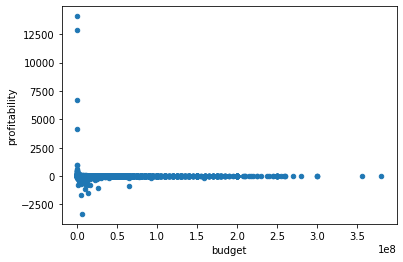

In [1039]:
%matplotlib inline
import matplotlib.pyplot as plt
df_profit.plot.scatter('budget','profitability')

In [1040]:
for i in range(1,11):
    df_profit.loc[df_profit[f'cast_{i}_name'] == ' ', f'cast_{i}_name'] = ''

In [1041]:
actors = pd.concat([df_profit[[f'cast_{i}_id', f'cast_{i}_name']]
               .rename(columns={ f'cast_{i}_id': 'id', f'cast_{i}_name': 'name'})
               for i in range (1, 11)], sort=False, axis=0)

In [1042]:
actors.shape

(75360, 2)

In [1043]:
group = actors.groupby('name')['id'].unique()
actors_duplicates = group[group.apply(lambda x: len(x)>1)]

In [1044]:
actors_duplicates.shape[0]/actors.shape[0]*100

0.10615711252653928

In [1045]:
for i in range(1,11):
    df_profit.drop(f'cast_{i}_id', axis=1, inplace=True)

In [1046]:
gender = pd.concat([df_profit[[f'cast_{i}_name', f'cast_{i}_gender']]
               .rename(columns={ f'cast_{i}_name': 'name', f'cast_{i}_gender': 'gender'})
               for i in range (1, 11)], sort=False)

In [1047]:
gender[gender.gender == 0].shape

(12497, 2)

In [1051]:
df_profit['day_sin'] = np.sin(2.*np.pi*(df_profit.day-1)/30)
df_profit['day_cos'] = np.cos(2.*np.pi*(df_profit.day-1)/30)
df_profit['month_sin'] = np.sin(2.*np.pi*(df_profit.month-1)/11)
df_profit['month_cos'] = np.cos(2.*np.pi*(df_profit.month-1)/11)

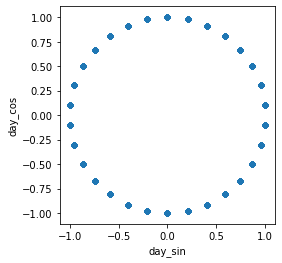

In [1054]:
df_profit.plot.scatter('day_sin','day_cos').set_aspect('equal');

In [1026]:
df_profit.columns.shape

(203,)

In [1027]:
pd.concat([df_profit[[f'production_company_{i}']]
               .rename(columns={ f'production_company_{i}': 'company'})
               for i in range (1, 5)], sort=False)['company'].unique().shape

(6470,)

In [1028]:
df_profit.drop(['genre__science_fiction', 'genre__tv_movie', 'country__al'], axis=1, inplace=True)

In [1029]:
list(df_profit.columns)

['budget',
 'id',
 'original_language',
 'original_title',
 'overview',
 'revenue',
 'runtime',
 'spoken_languages',
 'tagline',
 'title',
 'year',
 'month',
 'day',
 'weekend',
 'collection_name',
 'cast_1_name',
 'cast_1_gender',
 'cast_2_name',
 'cast_2_gender',
 'cast_3_name',
 'cast_3_gender',
 'cast_4_name',
 'cast_4_gender',
 'cast_5_name',
 'cast_5_gender',
 'cast_6_name',
 'cast_6_gender',
 'cast_7_name',
 'cast_7_gender',
 'cast_8_name',
 'cast_8_gender',
 'cast_9_name',
 'cast_9_gender',
 'cast_10_name',
 'cast_10_gender',
 'crew__lighting__gaffer',
 'crew__sound__boom_operator',
 'crew__sound__dialogue_editor',
 'crew__sound__foley',
 'crew__sound__music',
 'crew__sound__music_editor',
 'crew__sound__music_supervisor',
 'crew__sound__original_music_composer',
 'crew__sound__sound_designer',
 'crew__sound__sound_effects_editor',
 'crew__sound__sound_mixer',
 'crew__sound__sound_re_recording_mixer',
 'crew__sound__supervising_sound_editor',
 'crew__directing__director__1',
 '

In [1030]:
df_profit.shape

(7536, 200)

In [1031]:
df_profit['collection_exists'] = df_profit.apply(lambda x: int(x.collection_name != ''), axis=1)

In [1013]:
df_profit.to_csv('10 df.csv', mode='w+', index=False)

In [1034]:
df_profit.describe()

,budget,id,revenue,runtime,spoken_languages,year,month,day,weekend,cast_1_gender,cast_2_gender,cast_3_gender,cast_4_gender,cast_5_gender,cast_6_gender,cast_7_gender,cast_8_gender,cast_9_gender,cast_10_gender,genre__war,genre__western,genre__mystery,genre__music,genre__crime,genre__romance,genre__action,genre__adventure,genre__thriller,genre__animation,genre__family,genre__drama,genre__comedy,genre__documentary,genre__history,genre__fantasy,genre__horror,country__rs,country__su,country__do,country__bo,country__ph,country__pe,country__id,country__gr,country__hn,country__nl,country__ee,country__ug,country__uy,country__ir,country__lb,country__pk,country__ua,country__eg,country__is,country__co,country__sk,country__bw,country__es,country__se,country__jp,country__np,country__tw,country__ie,country__lu,country__us,country__vn,country__ro,country__mn,country__cl,country__hu,country__br,country__ae,country__kr,country__be,country__ca,country__sg,country__bg,country__de,country__pl,country__mv,country__cn,country__in,country__th,country__fr,country__ru,country__dk,country__af,country__xg,country__it,country__ge,country__tr,country__za,country__ve,country__lk,country__hr,country__ng,country__ar,country__ba,country__il,country__mx,country__bd,country__my,country__nz,country__no,country__cz,country__hk,country__au,country__gb,country__lv,country__fi,profitability,day_sin,day_cos,month_sin,month_cos,collection_exists
count,7.536000e+03,7536.000000,7.536000e+03,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.00000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.00000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7.536000e+03,7536.000000,7.536000e+03,7536.000000,7536.000000
mean,2.713406e+07,107523.461651,7.751832e+07,109.768179,1.453025,2001.580547,6.882696,15.264199,0.081476,1.584130,1.478636,1.483678,1.468153,1.447054,1.387473,1.337845,1.278530,1.221868,1.173301,0.035297,0.016056,0.077627,0.035563,0.147956,0.190154,0.245886,0.158307,0.251990,0.050955,0.101911,0.488854,0.360801,0.013668,0.046975,0.091162,0.108413,0.000929,0.000133,0.000265,0.000265,0.001592,0.000796,0.000796,0.001327,0.000133,0.004512,0.000398,0.000265,0.000265,0.006104,0.000265,0.003583,0.001062,0.000796,0.000663,0.000663,0.000531,0.000133,0.019241,0.007033,0.016720,0.000133,0.00146,0.007564,0.002654,0.757696,0.000398,0.002654,0.000133,0.000796,0.002389,0.00345,0.002521,0.006635,0.009421,0.043259,0.002389,0.001062,0.057988,0.001990,0.000133,0.014862,0.064490,0.002787,0.066879,0.017251,0.004777,0.000133,0.000133,0.020037,0.000133,0.003052,0.003185,0.000265,0.000265,0.000398,0.000133,0.002256,0.000398,0.001725,0.005706,0.000133,0.001062,0.005308,0.003185,0.004777,0.009687,0.021364,0.118498,0.000133,0.002787,3.383755,2.077445e-02,-0.031978,-6.348276e-02,0.073320,0.199973
std,3.803561e+07,154226.807257,1.626742e+08,22.741104,0.904855,16.028480,3.39

In [1035]:
list(df_profit.columns)

['budget',
 'id',
 'original_language',
 'original_title',
 'overview',
 'revenue',
 'runtime',
 'spoken_languages',
 'tagline',
 'title',
 'year',
 'month',
 'day',
 'weekend',
 'collection_name',
 'cast_1_name',
 'cast_1_gender',
 'cast_2_name',
 'cast_2_gender',
 'cast_3_name',
 'cast_3_gender',
 'cast_4_name',
 'cast_4_gender',
 'cast_5_name',
 'cast_5_gender',
 'cast_6_name',
 'cast_6_gender',
 'cast_7_name',
 'cast_7_gender',
 'cast_8_name',
 'cast_8_gender',
 'cast_9_name',
 'cast_9_gender',
 'cast_10_name',
 'cast_10_gender',
 'crew__lighting__gaffer',
 'crew__sound__boom_operator',
 'crew__sound__dialogue_editor',
 'crew__sound__foley',
 'crew__sound__music',
 'crew__sound__music_editor',
 'crew__sound__music_supervisor',
 'crew__sound__original_music_composer',
 'crew__sound__sound_designer',
 'crew__sound__sound_effects_editor',
 'crew__sound__sound_mixer',
 'crew__sound__sound_re_recording_mixer',
 'crew__sound__supervising_sound_editor',
 'crew__directing__director__1',
 '